<a href="https://colab.research.google.com/github/eursamajor/Hairapy/blob/main/Copy_of_Hairapy_IMGPROCESS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IMPORT LIBRARY**

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import urllib.request
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io

### **IMPORT DATA**

In [ ]:
url = 'https://github.com/eursamajor/Hairapy/raw/main/Dataset.zip'

local_path = './Dataset.zip'

urllib.request.urlretrieve(url, local_path)

with zipfile.ZipFile(local_path, 'r') as zip_ref:
    zip_ref.extractall('data')

dataset_dir = '/content/data/Dataset'

### **DATA PREPROCESSING**

In [ ]:
train_dir = dataset_dir

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

class_indices = train_generator.class_indices
# Reverse the dictionary to map indices to class names
class_indices = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

Found 314 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
Class indices: {0: 'Dandruff', 1: 'Hair Greasy', 2: 'Hair Loss', 3: 'Psoriasis'}


### **DEFINE MODEL**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobilenet.layers:
    layer.trainable = False

last_layer = mobilenet.get_layer('Conv_1') #potong layer
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=mobilenet.input, outputs=prediction)

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #rms

### **TRAIN MODEL**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('hairapy_model.h5', monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 5.7487 - accuracy: 0.5637

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 19s 2s/step - loss: 5.7487 - accuracy: 0.5637 - val_loss: 0.7319 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 8s 869ms/step - loss: 1.3378 - accuracy: 0.7420 - val_loss: 0.6567 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 7s 717ms/step - loss: 0.8546 - accuracy: 0.7994 - val_loss: 0.8913 - val_accuracy: 0.7632 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 7s 634ms/step - loss: 0.8735 - accuracy: 0.8089 - val_loss: 1.0177 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 8s 814ms/step - loss: 0.8191 - accuracy: 0.8121 - val_loss: 0.6887 - val_accuracy: 0.8684 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 7s 674ms/step - loss: 0.7969 - accuracy: 0.8185 - val_loss: 0.8023 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - 8

### **PLOT ACCURACY**

In [ ]:
model.save('hairapy.h5')

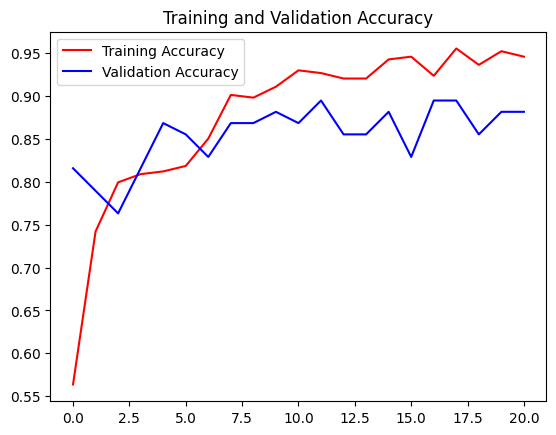

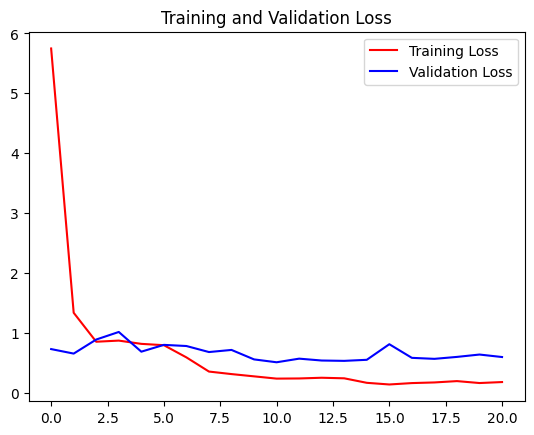

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

##**TESTING**

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 1s/step


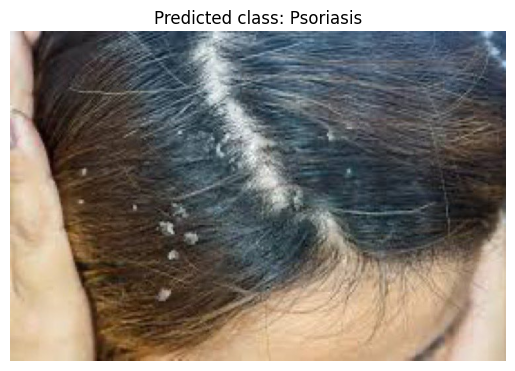

Predicted class: Psoriasis
Prediction probabilities: [[0.00104705 0.00707805 0.00363898 0.9882359 ]]
1/1 [==============================] - 0s 35ms/step


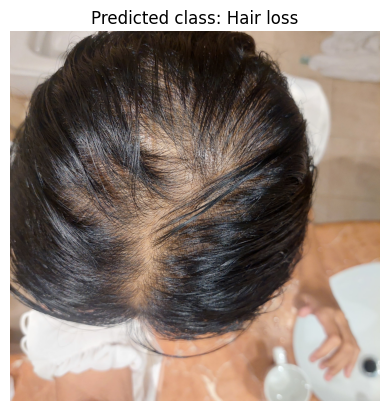

Predicted class: Hair loss
Prediction probabilities: [[0.00122892 0.32611644 0.66603804 0.00661652]]
1/1 [==============================] - 0s 21ms/step


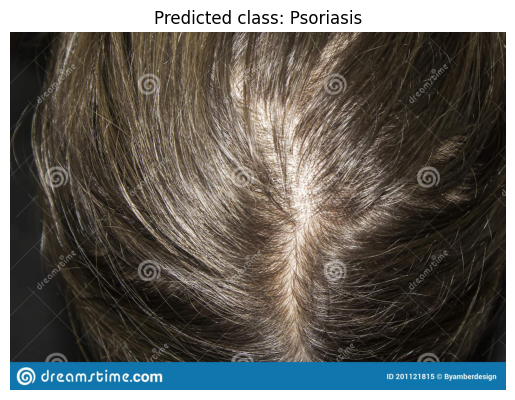

Predicted class: Psoriasis
Prediction probabilities: [[0.02911764 0.1879243  0.13971539 0.64324266]]


In [ ]:
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

def predict_image_class(model, img_array, class_indices):
    predictions = model.predict(img_array)
    predicted_class = class_indices[np.argmax(predictions)]
    return predicted_class, predictions

# Load the saved model
model = load_model('hairapy_model.h5')

# Class indices (ensure this matches your training data class indices)
class_indices = {0: 'Dandruff', 1: 'Hair Greasy', 2: 'Hair loss', 3: 'Psoriasis'}

# Widget for file upload
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_widget)

def on_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        img_array = preprocess_image(img)
        predicted_class, predictions = predict_image_class(model, img_array, class_indices)

        # Display the uploaded image
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()

        print(f"Predicted class: {predicted_class}")
        print(f"Prediction probabilities: {predictions}")

upload_widget.observe(on_upload_change, names='value')

##**EVALUATION**

In [ ]:
test_data_url = 'https://github.com/eursamajor/Hairapy/raw/main/Test%20Dataset.zip'
test_data_zip = './TestData.zip'

urllib.request.urlretrieve(test_data_url, test_data_zip)

with zipfile.ZipFile(test_data_zip, 'r') as zip_ref:
    zip_ref.extractall('./data')

test_dataset_dir = '/content/data/Dataset'

In [ ]:
test_dir = test_dataset_dir

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 390 images belonging to 4 classes.
